# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Function to read files using read_csv from pandas
def le_arq(nome, sep):
    df_temp = pd.read_csv(nome, sep, engine='c')
    return df_temp


In [3]:
# Load in the general demographics data.
azdias = le_arq('Udacity_AZDIAS_Subset.csv', ';')

# Load in the feature summary file.
feat_info =  le_arq('AZDIAS_Feature_Summary.csv', ';')

In [4]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.head(5)


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [5]:
# Getting more information about dataset
azdias.shape

(891221, 85)

In [6]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [7]:
# What is the quantity of nulls of dataset?
azdias.isnull().sum()

AGER_TYP                      0
ALTERSKATEGORIE_GROB          0
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR                   0
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP                    0
LP_LEBENSPHASE_FEIN        4854
LP_LEBENSPHASE_GROB        4854
LP_FAMILIE_FEIN            4854
LP_FAMILIE_GROB            4854
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ              0
PRAEGENDE_JUGENDJAHRE         0
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

In [8]:
# Taking a look at features
feat_info.shape

(85, 4)

In [9]:
feat_info.head(8)

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]


In [10]:
feat_info['missing_or_unknown'].unique()

array(['[-1,0]', '[-1,0,9]', '[0]', '[-1]', '[]', '[-1,9]', '[-1,X]',
       '[XX]', '[-1,XX]'], dtype=object)

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [11]:
# Identify missing or unknown data values and convert them to NaNs.
print('Total of Miss Values before convert unknown to nan', azdias.isnull().sum().sum())


Total of Miss Values before convert unknown to nan 4896838


In [12]:
def replace_nan(info, df):
    # dictionary with key:column and value:missing value
    dic_col_nan = dict(zip(info['attribute'], info['missing_or_unknown']))
    #print(dic_col_nan)

    # Iterating data frame by column name with dictionary key (and value)
    for key in dic_col_nan:  # for each column 
        val = dic_col_nan[key] #getting value list representing nan 
        val = val.strip('[') # removing '[]''
        val = val.strip(']')
        val = val.split(',')

        # Converting values null to nan 
        if len(val)>=1 and val[0]!='':
            for v in val:
                df[key].replace( int(v) if (v!='X' and v!='XX') else v, np.nan , inplace=True) 
                
    # return dataframe with missing values replaced by nan 
    return df            


In [13]:
azdias = replace_nan(feat_info, azdias)    
        

In [14]:
# Identify missing or unknown data values before convert miss values to NaNs.
print('Total of Miss Values after convert unknown to Nan:', azdias.isnull().sum().sum())


Total of Miss Values after convert unknown to Nan: 8373929


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [15]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
def get_miss_col(df):
    miss_col = df.isnull().sum()/df.shape[0]*100
    miss_col.sort_values(ascending=False, inplace=True)
    
    return miss_col

In [16]:

miss_col = get_miss_col(azdias)
print('% Nulls by Missing Columns:\n',miss_col)

% Nulls by Missing Columns:
 TITEL_KZ                 99.757636
AGER_TYP                 76.955435
KK_KUNDENTYP             65.596749
KBA05_BAUMAX             53.468668
GEBURTSJAHR              44.020282
ALTER_HH                 34.813699
REGIOTYP                 17.735668
KKK                      17.735668
W_KEIT_KIND_HH           16.605084
KBA05_ANTG4              14.959701
KBA05_GBZ                14.959701
MOBI_REGIO               14.959701
KBA05_ANTG1              14.959701
KBA05_ANTG2              14.959701
KBA05_ANTG3              14.959701
PLZ8_GBZ                 13.073637
PLZ8_HHZ                 13.073637
PLZ8_BAUMAX              13.073637
PLZ8_ANTG4               13.073637
PLZ8_ANTG1               13.073637
PLZ8_ANTG3               13.073637
PLZ8_ANTG2               13.073637
SHOPPER_TYP              12.476816
VERS_TYP                 12.476816
HEALTH_TYP               12.476816
NATIONALITAET_KZ         12.153551
PRAEGENDE_JUGENDJAHRE    12.136608
KBA13_ANZAHL_PKW         1

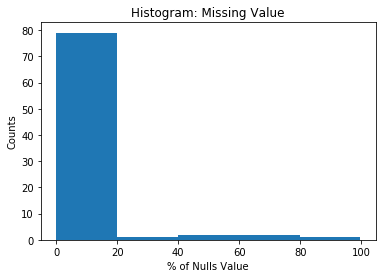

In [17]:
# Investigate patterns in the amount of missing data in each column.
plt.hist(miss_col, bins=5)
plt.xlabel('% of Nulls Value')
plt.ylabel('Counts')
plt.title('Histogram: Missing Value')
plt.show()

As we can see at the histrogram: Missing value (above), the most of features have betweeen 0 and 20% of missing values, but there are few features that have more then 20% up to 99% of missing values, they seems to be outliers.   

In [18]:
def del_outliers_col(miss_col, df):
    # Getting outliers columns names
    outliers =  list(miss_col[miss_col>20.0].index)
    
    print('Outliers Columns:', outliers)
    print('Deleting Outliers Columns (>20% miss values)')
    
    # removing outliers columns
    df.drop(outliers, axis=1, inplace=True)
    return df, outliers

In [19]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
azdias, outliers = del_outliers_col(miss_col, azdias)

Outliers Columns: ['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH']
Deleting Outliers Columns (>20% miss values)


In [20]:
azdias.shape

(891221, 79)

In [21]:
azdias.tail(5)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
891216,3.0,2,5.0,1,4,2,5,4,4,1,...,3.0,2.0,0.0,0.0,1.0,2.0,3.0,NaN,NaN,NaN
891217,2.0,1,4.0,3,3,3,2,2,3,6,...,1.0,3.0,3.0,2.0,4.0,5.0,3.0,4.0,6.0,5.0
891218,2.0,2,4.0,2,4,2,5,4,3,1,...,4.0,2.0,0.0,0.0,1.0,3.0,4.0,2.0,2.0,3.0
891219,1.0,1,3.0,1,5,3,5,5,5,1,...,1.0,4.0,3.0,1.0,5.0,1.0,1.0,4.0,7.0,5.0
891220,4.0,1,1.0,4,2,5,2,1,5,6,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,4.0,5.0


#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

From 85 columns, six of them (7% of the columns) presented more than 20% of missing values, in contrast, 92.94% of columns were composed by less than 20% of missing values. That six columns mentioned were considered outliers (due has been different from the 92.94% other columns composition). Then, outliers were removed from dataset.  

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.


Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [22]:
# How much data is missing in each row of the dataset?
miss_row = azdias.isnull().sum(axis=1)
#miss_row

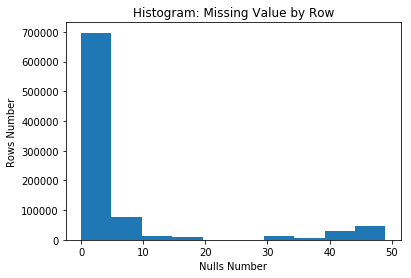

In [23]:
plt.hist(miss_row)
plt.xlabel('Nulls Number')
plt.ylabel('Rows Number')
plt.title('Histogram: Missing Value by Row')
plt.show()

In [24]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
def get_subsets(df, miss_row):
    ind_up_20 = miss_row[miss_row.values<=20].index
    ind_more_20 = miss_row[miss_row.values>20].index

    # Dividing the data into 2 subsets
    up_to_20 = df.loc[ind_up_20]
    more_than_20 = df.loc[ind_more_20]
    return up_to_20, more_than_20


In [25]:
up_to_20, more_than_20 = get_subsets(azdias, miss_row)

In [26]:
up_to_20.shape

(797426, 79)

In [27]:
more_than_20.shape

(93795, 79)

In [28]:
more_than_20.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,2.0,1,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,3.0,1,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,2.0,1,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24,3.0,2,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
def plot_subsets(subset1, subset2, name):
    fig = plt.figure(10, figsize=(12,4))
    
    ax1 = fig.add_subplot(121)
    ax1.title.set_text('More Missing Rows ')
    sns.countplot(subset1[name])
    
    ax2 = fig.add_subplot(122)
    ax2.title.set_text('Less Missing Rows')
    sns.countplot(subset2[name])
                                                       
    fig.suptitle(name)
    plt.show()


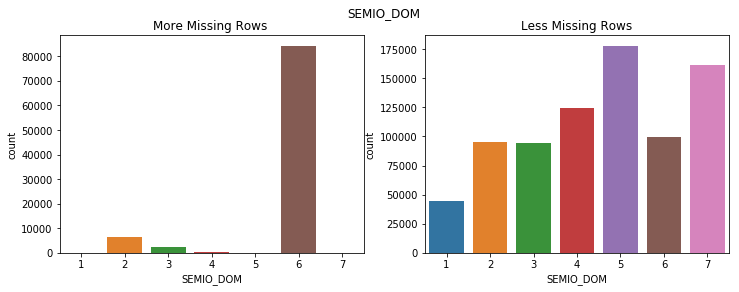

In [30]:
plot_subsets(more_than_20, up_to_20, 'SEMIO_DOM' )

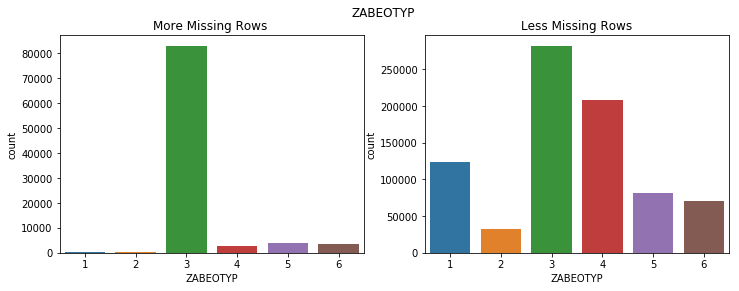

In [31]:
plot_subsets(more_than_20, up_to_20, 'ZABEOTYP' )

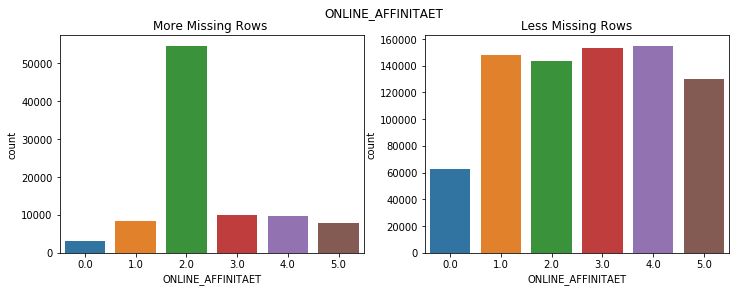

In [32]:
plot_subsets(more_than_20, up_to_20, 'ONLINE_AFFINITAET' )

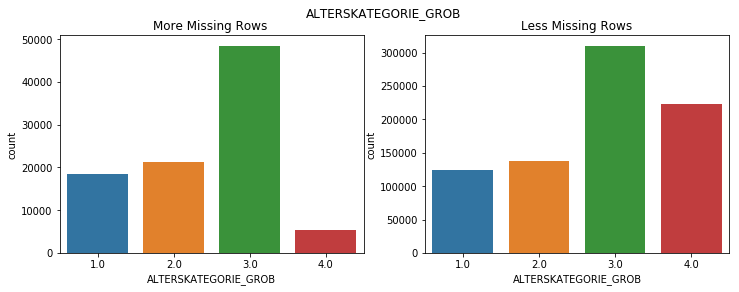

In [33]:
plot_subsets(more_than_20, up_to_20, 'ALTERSKATEGORIE_GROB' )

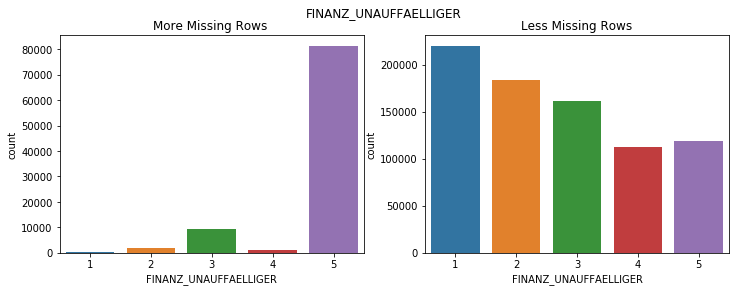

In [34]:
plot_subsets(more_than_20, up_to_20, 'FINANZ_UNAUFFAELLIGER' )

#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

According to the plots above, the data with lots of missing value has distributions differents from data with few or no missing values ( just 1 feature ALTERSTAKE_CATEGORIE_GROB had the same distribution for both subsets). So, it will be remained both subsets, trying not to loose any information.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [35]:
Ind = []
Ind = feat_info[feat_info['attribute'].isin(outliers)].index
print(Ind)

# Removing from feat_info rows of features previously removed from dataset azdias 
feat_info.drop(Ind, inplace=True)

Int64Index([0, 11, 40, 43, 47, 64], dtype='int64')


In [36]:
feat_info.shape

(79, 4)

In [37]:
feat_info['type'].unique()

array(['ordinal', 'categorical', 'mixed', 'numeric'], dtype=object)

In [38]:
# How many features are there of each data type?
feat_info['type'].value_counts()


ordinal        49
categorical    18
numeric         6
mixed           6
Name: type, dtype: int64

In [39]:
categorical_names = list(feat_info[feat_info['type']=='categorical'].attribute)
categorical_names

['ANREDE_KZ',
 'CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'GREEN_AVANTGARDE',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'SOHO_KZ',
 'VERS_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'OST_WEST_KZ',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [40]:
mixed_names = list(feat_info[feat_info['type']=='mixed'].attribute)
mixed_names

['LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'PRAEGENDE_JUGENDJAHRE',
 'WOHNLAGE',
 'CAMEO_INTL_2015',
 'PLZ8_BAUMAX']

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [41]:
# filling nan values with most commom value
cols = list(feat_info['attribute'])
for col in cols:
    azdias[col].fillna(azdias[col].mode()[0], inplace=True)


In [42]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
def get_categ_values(df, categorical_names):
    cat_values = {}
    more_2 = []
    up_2 = []

    for categ in categorical_names:
        cat_values[categ] = len(list(df[categ].unique()))
        if cat_values[categ] > 2:
            more_2.append(categ) 
        else:
            up_2.append(categ)        
    
    print(cat_values)
    return more_2, up_2 

In [43]:
# Getting collumns more than 2 categories and less up to 2 categories
more_2, up_2 = get_categ_values(azdias, categorical_names)

{'ANREDE_KZ': 2, 'CJT_GESAMTTYP': 6, 'FINANZTYP': 6, 'GFK_URLAUBERTYP': 12, 'GREEN_AVANTGARDE': 2, 'LP_FAMILIE_FEIN': 11, 'LP_FAMILIE_GROB': 5, 'LP_STATUS_FEIN': 10, 'LP_STATUS_GROB': 5, 'NATIONALITAET_KZ': 3, 'SHOPPER_TYP': 4, 'SOHO_KZ': 2, 'VERS_TYP': 2, 'ZABEOTYP': 6, 'GEBAEUDETYP': 7, 'OST_WEST_KZ': 2, 'CAMEO_DEUG_2015': 9, 'CAMEO_DEU_2015': 44}


In [44]:
up_2

['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']

In [45]:
more_2

['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [46]:
# Re-encode categorical variable(s) to be kept in the analysis.
from sklearn import preprocessing

def re_encode_cat(df, up_to):
    lb = preprocessing.LabelEncoder()
    for col in up_2:
        df[col] = lb.fit_transform(df[col])
    return df

In [47]:
azdias_base = re_encode_cat(azdias, up_2)

In [48]:
# Removing categorical variabels with more than 2 values
azdias_base.drop(columns=more_2, inplace=True)

In [49]:
#up_to_20.shape
azdias_base.shape

(891221, 66)

#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)
+ It was used the dataset of rows with less than 20 miss values, got in the previous step.
+ Features had Nan values filled with most common value (mode) 
+ For Binary Categorical Features - Was made Re-Encoded Process
+ Multi-Level Categorical Features - Were removed from the database, because using multiple dummy variables could increase the dimensionality. 

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [50]:
dic = open('Data_Dictionary.md', 'r')

In [51]:
dic
for linha in dic:
     print(linha)

# Data Dictionary for Identify Customer Segments Data



## Introduction



The data for this project consist of two files:



- Udacity_AZDIAS_Subset.csv: demographics data for the general population of

      Germany; 891211 persons (rows) x 85 features (columns)

- Udacity_CUSTOMERS_Subset.csv: demographics data for customers of a mail-order

      company; 191652 persons (rows) x 85 features (columns)



The columns in the general demographics file and customers data file are the

same. This file documents the features that appear in the data files, sorted in

order of appearance. Sections of this file is based on the level of measurement

of each feature. The file "AZDIAS_Feature_Summary.csv" contains a summary of

feature attributes, including information level, data type, and codes for

missing or unknown values.



### Table of Contents



 1. Person-level features

 2. Household-level features

 3. Building-level features

 4. RR4 micro-cell features

 5. RR3 micro-cell featur

In [52]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

def decade_map(x):
    if x in [1,2]:
        return 0
    elif x in [3,4]:
        return 1
    elif x in [5,6,7]:
        return 2
    elif x in [8,9]:
        return 3
    elif x in [10,11,12,13]:
        return 4
    elif x in [14,15]:
        return 5


azdias_base['DECADE'] = azdias_base['PRAEGENDE_JUGENDJAHRE'].apply(decade_map)
azdias_base['DECADE'].unique()


array([5, 3, 1, 4, 2, 0])

In [53]:
def mov_map(x):
    if x in [1,3,5,8,10,12,14]: # mapping mainstrain 0
        return 0 
    else:
        return 1 #Avantgarde
    
azdias_base['MOVEMENT'] = azdias_base['PRAEGENDE_JUGENDJAHRE'].apply(mov_map)
azdias_base['MOVEMENT'].unique()



array([0, 1])

In [54]:
# Dropping PRAEGENDE_JUGENDJAHRE, that was replaced by moviment and decade
azdias_base.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)

In [55]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

azdias_base['CAMEO_INTL_2015'] = azdias_base['CAMEO_INTL_2015'].apply(pd.to_numeric)
print('Before mapping:', azdias_base['CAMEO_INTL_2015'].unique())

azdias_base['LIFE_STAGE'] = azdias_base['CAMEO_INTL_2015'].apply( lambda x: (x%10) )
print('After mapping:', azdias_base['LIFE_STAGE'].unique())

Before mapping: [51 24 12 43 54 22 14 13 15 33 41 34 55 25 23 31 52 35 45 44 32]
After mapping: [1 4 2 3 5]


In [56]:
# Engineer new variable Wealth
azdias_base['WEALTH'] = azdias_base['CAMEO_INTL_2015'].apply( lambda x: (x//10) )
azdias_base['WEALTH'].unique()

array([5, 2, 1, 4, 3])

In [57]:
# Dropping Cameo_intl_2015 that was replaced by the new ones: Life_stage and Wealth
azdias_base.drop('CAMEO_INTL_2015', axis=1, inplace=True)

In [58]:
# Variables Results from Engineer up to here
colunas = list(azdias_base.columns)
print('Colunas:',colunas)
print('Shape:', azdias_base.shape)

Colunas: ['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GREEN_AVANTGARDE', 'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV', 'SOHO_KZ', 'VERS_TYP', 'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'KONSUMNAEHE', 'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'WOHNLAGE', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_GBZ', 'BALLRAUM', 'EWDICHTE', 'INNENSTADT', 'GEBAEUDETYP_RASTER', 'KKK', 'MOBI_REGIO', 'ONLINE_AFFINITAET', 'REGIOTYP', 'KBA13_ANZAHL_PKW', 'PLZ8_ANTG1', 'PLZ8_ANTG2', 'PLZ8_ANTG3', 'PLZ8_ANTG4', 'PLZ8_BAUMAX', 'PLZ8_HHZ', 'PLZ8_GBZ', 'ARBEIT', 'ORTSGR_KLS9', 'RE

#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

+ For each mixed type feature were applied mapping functions, that associated integers to represent each possible value, creating two new ones to replace original.
+ To replace PRAEGENDE_JUGENDJAHRE, were generated the following features: DECADE and MOVEMENT. After that, the original feature PRAEGENDE_JUGENDJAHR was removed.
+ To replace CAMEO_INTL_2015 were generated:  and LIFE_STAGE WEALTH WEALTH. After, the original feature CAMEO_INTL_2015 was dropped. 

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [59]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
azdias_base.dtypes.unique()

array([dtype('float64'), dtype('int64')], dtype=object)

In [60]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
azdias_base.isnull().sum().sum()


0

In [61]:
#up_to_20.shape
azdias_base.shape

(891221, 68)

In [62]:
 """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
"""
def clean_data(df, feat_info):
    
    # First Step: Convert missing value codes into NaNs, ...
    df = replace_nan(feat_info, df)    
   
    # Second Step: Removing selected columns and rows, ...           
    df, outliers = del_outliers_col(miss_col, df)      # Removing selected columns (with more than 20% of missing data)
    #miss_row = df.isnull().sum(axis=1)       # Getting missing data by rows and separate data into two subsets 
    #df, df_more_than_20 = get_subsets(df, miss_row)
    
    # Third Step: Fill nan with mode   
    cols = list(set(feat_info['attribute']) - set(outliers)) 
    for col in cols:
        df[col].fillna(df[col].mode()[0], inplace=True)
   
    # Fourth Step: Select, Re-Encode, and Engineer Column Values.
    categorical_names = list(feat_info[feat_info['type']=='categorical'].attribute)    
    #print('Categorical Names:', categorical_names)
    more_2, up_2 = get_categ_values(df, categorical_names)    # Getting columns with more than 2 categories and up to 2 categories
    df = re_encode_cat(df, up_2)                              # Encoding Categorical Features (Binary)
    
    # Removing categorical variabels with more than 2 values
    df.drop(columns=more_2, inplace=True)
    mixed_names = list(feat_info[feat_info['type']=='mixed'].attribute)

    # Generating two new features from PRAEGENDE_JUGENDJAHRE
    df['DECADE'] = df['PRAEGENDE_JUGENDJAHRE'].apply(decade_map)
    df['MOVEMENT'] = df['PRAEGENDE_JUGENDJAHRE'].apply(mov_map)
    df.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)     # Removing original PRAEGENDE_JUGENDJAHRE
    
    # Generating two new features derived from CAMEO_INTL_2015  
    df['CAMEO_INTL_2015'] = df['CAMEO_INTL_2015'].apply(pd.to_numeric)   #mapping to numeric
    df['LIFE_STAGE'] = df['CAMEO_INTL_2015'].apply( lambda x: (x%10) )
    df['WEALTH'] = df['CAMEO_INTL_2015'].apply( lambda x: (x//10) )
    df.drop('CAMEO_INTL_2015', axis=1, inplace=True)     # removing original feature

    
    # Return the cleaned dataframe.
    return df
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [63]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
azdias_base.isnull().sum().sum()


0

In [64]:
# Apply feature scaling to the general population demographics data.
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
cols = list(azdias_base.columns)

base = scaler.fit_transform(azdias_base)
base = pd.DataFrame(base, columns=cols)



In [65]:
base.head(5)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,LIFE_STAGE,WEALTH
0,-0.751680,-1.045218,-0.056416,0.804890,-0.303378,1.285741,1.429871,-0.055511,-0.494701,0.938197,...,-0.587083,-0.572015,-0.317206,0.758890,-0.120115,-0.049267,0.994991,-0.494701,-1.095866,1.039938
1,-1.743339,0.956738,-1.570358,1.487601,-1.059731,1.285741,0.757254,1.422415,-0.494701,0.938197,...,-0.587083,1.575581,0.640354,-0.263506,-0.120115,0.729399,0.994991,-0.494701,-1.095866,1.039938
2,0.239980,0.956738,-1.570358,0.804890,-1.816084,-0.675554,0.084637,1.422415,2.021423,0.938197,...,-0.587083,0.501783,0.640354,-0.263506,-0.120115,-0.827934,0.994991,2.021423,0.879581,-0.980453
3,1.231640,0.956738,0.700556,-0.560532,1.209329,-0.675554,-1.260597,-0.794475,-0.494701,-0.385397,...,-0.587083,-0.572015,0.640354,-1.285903,-1.039247,-0.049267,-0.363493,-0.494701,-0.437384,-1.653917
4,0.239980,-1.045218,0.700556,0.122179,0.452976,-1.329319,0.084637,-0.794475,-0.494701,0.938197,...,0.128428,-0.572015,-0.317206,0.758890,0.339451,1.508065,-0.363493,-0.494701,0.221098,0.366474


### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

+ Previously, it was made an imputation of null data by applying the most common value of those data. So, It doesn't need to be done in this step.
+ It was applied standard scaler function, getting data scaled.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [66]:
base.shape

(891221, 68)

In [67]:
# Apply PCA to the data.
from sklearn.decomposition import PCA

pca = PCA()
pca_base = pca.fit_transform(base)


In [68]:
# Investigate the variance accounted for by each principal component.
def plot_var(pca):
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance');


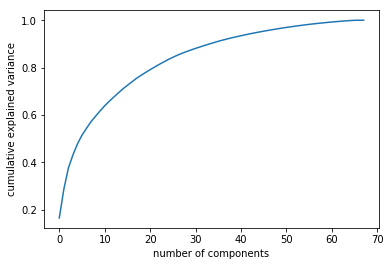

In [69]:
plot_var(pca)

In [70]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca_2 = PCA(35)
pca_base_2 = pca_2.fit_transform(base)



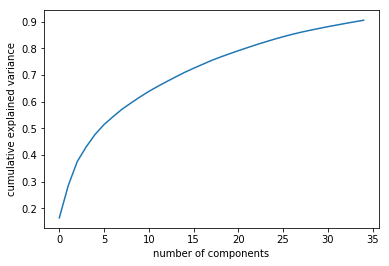

In [71]:
plot_var(pca_2)

In [72]:
print('Cumulative Explained Component Using 35 Features:', np.cumsum(pca_2.explained_variance_ratio_)[34])


Cumulative Explained Component Using 35 Features: 0.905203001955


### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

+ According to the plots and cell print above, we can see that using 35 features like the number of components, it reaches 90% of the cumulative variance explained. Thus, it was chosen uses 35 features, looks a good/enough % of variability explained.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [73]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def map_weights(pca, cols, comp_number):
    df = pd.DataFrame(pca.components_, columns=cols)
    names_weights = df.iloc[comp_number].sort_values(ascending=False)
    return names_weights


In [74]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
comp_0 = map_weights(pca_2, cols , 0)
print(comp_0)


PLZ8_ANTG3               0.223054
WEALTH                   0.203220
EWDICHTE                 0.197492
PLZ8_BAUMAX              0.188013
ORTSGR_KLS9              0.186948
PLZ8_ANTG4               0.180791
PLZ8_ANTG2               0.152456
FINANZ_HAUSBAUER         0.150404
FINANZ_SPARER            0.148143
ARBEIT                   0.147245
HH_EINKOMMEN_SCORE       0.146939
KBA05_ANTG4              0.135423
RELAT_AB                 0.127557
ANZ_HAUSHALTE_AKTIV      0.117795
SEMIO_REL                0.117113
KBA05_ANTG3              0.114465
SEMIO_PFLICHT            0.113687
DECADE                   0.112993
FINANZ_UNAUFFAELLIGER    0.093334
SEMIO_RAT                0.092299
FINANZ_ANLEGER           0.086121
SEMIO_MAT                0.079444
SEMIO_FAM                0.078200
SEMIO_TRADV              0.071643
REGIOTYP                 0.070044
W_KEIT_KIND_HH           0.066778
SEMIO_KAEM               0.064231
HEALTH_TYP               0.056149
VERS_TYP                 0.048712
SEMIO_DOM     

In [75]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
comp_1 = map_weights(pca_2, cols , 1)
print(comp_1)


ALTERSKATEGORIE_GROB     0.262713
FINANZ_VORSORGER         0.241494
SEMIO_ERL                0.219633
SEMIO_LUST               0.177637
RETOURTYP_BK_S           0.170371
FINANZ_HAUSBAUER         0.117901
PLZ8_ANTG4               0.117768
PLZ8_BAUMAX              0.109557
ORTSGR_KLS9              0.105923
W_KEIT_KIND_HH           0.096974
PLZ8_ANTG3               0.093302
KBA05_ANTG4              0.085439
ANZ_HAUSHALTE_AKTIV      0.077662
HH_EINKOMMEN_SCORE       0.076801
FINANZ_MINIMALIST        0.075955
EWDICHTE                 0.072332
RELAT_AB                 0.072100
PLZ8_ANTG2               0.065021
KBA05_ANTG3              0.060808
SEMIO_KAEM               0.058851
ARBEIT                   0.054544
SEMIO_KRIT               0.054442
ANREDE_KZ                0.052673
WOHNDAUER_2008           0.048009
WEALTH                   0.047404
ANZ_HH_TITEL             0.037239
PLZ8_HHZ                 0.029095
SEMIO_DOM                0.026958
LIFE_STAGE               0.026788
KBA05_ANTG2   

In [76]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
comp_2 = map_weights(pca_2, cols , 2)
print(comp_2)



SEMIO_VERT               0.347179
SEMIO_SOZ                0.298502
SEMIO_KULT               0.291761
SEMIO_FAM                0.225147
PLZ8_ANTG4               0.105363
PLZ8_BAUMAX              0.098567
FINANZ_MINIMALIST        0.091284
SEMIO_MAT                0.077200
ORTSGR_KLS9              0.069821
GREEN_AVANTGARDE         0.064759
MOVEMENT                 0.064759
SEMIO_REL                0.061928
RETOURTYP_BK_S           0.060557
KBA05_ANTG4              0.057104
ANZ_HAUSHALTE_AKTIV      0.055795
HH_EINKOMMEN_SCORE       0.054852
KBA05_ANTG3              0.045509
PLZ8_ANTG3               0.044669
RELAT_AB                 0.040589
ANZ_PERSONEN             0.037849
LP_LEBENSPHASE_FEIN      0.037113
KBA05_ANTG2              0.035918
LIFE_STAGE               0.033225
FINANZ_VORSORGER         0.031075
PLZ8_HHZ                 0.030943
PLZ8_ANTG2               0.028015
LP_LEBENSPHASE_GROB      0.026685
ANZ_HH_TITEL             0.021456
SEMIO_TRADV              0.017495
MOBI_REGIO    

### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

+ The first principal component has the following relashionship between features:
   - Positive association between: 
         PLZ8_ANTG3 Number of 6-10 family houses in the PLZ8 region
         WEALTH
   - Negative association between:
         PLZ8_ANTG1 Number of 1-2 family houses in the PLZ8 region
         MOBI_REGIO Movement patterns
+ The second principal component has the following relashionship between features:
   - Positive association between: 
       ALTERSKATEGORIE_GROB     Estimated age based on given name analysis
       FINANZ_VORSORGER         Financial tipology
   - Negative association between:
       SEMIO_REL               
       DECADE      Decade of movement of person's youth (extracted feature)              
+ The third principal component has the following relashionship between features:    
    - Positive association between: 
       SEMIO_VERT   Personality typology, dreamful           
       SEMIO_SOZ    Personality typology, socially-minded  
    - Negative association between:
       ANREDE_KZ    Gender
       SEMIO_KAEM   Personality typology, combative attitude         

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [77]:
from sklearn.cluster import KMeans

In [78]:
# Over a number of different cluster counts...
# run k-means clustering on the data and...
# compute the average within-cluster distances.

def run_kmeans(num_clusters, base):

    k_means = KMeans(n_clusters=num_clusters, random_state=42)
    k_means_model = k_means.fit(base)
    score = k_means_model.score(base)
    return score
    

In [81]:
from time import time

keys = list(range(20, 31)) # from 20 to 30 clusters
scores = []

start = time()

for key in keys:
    score = run_kmeans(key, pca_base_2)
    scores.append(score)
    print('Clusters Number:', key, 'Average Score:', score)
end = time()

print('Time:', (end-start)/60, 'Minutes')



Clusters Number: 20 Average Score: -28974080.4047
Clusters Number: 21 Average Score: -28638915.8016
Clusters Number: 22 Average Score: -28249196.8443
Clusters Number: 23 Average Score: -27790001.8284
Clusters Number: 24 Average Score: -27824379.7692
Clusters Number: 25 Average Score: -27497754.9399
Clusters Number: 26 Average Score: -27175352.7898
Clusters Number: 27 Average Score: -26995527.8003
Clusters Number: 28 Average Score: -26750358.3093
Clusters Number: 29 Average Score: -26575620.8393
Clusters Number: 30 Average Score: -26380655.3215
Time: 104.12471377452215 Minutes


Text(0.5,1,'Averange Distance - K clusters')

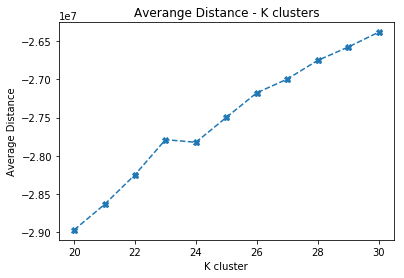

In [82]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

plt.plot(keys, scores, linestyle='--', marker='X')
plt.xlabel('K cluster')
plt.ylabel('Average Distance')
plt.title('Averange Distance - K clusters')

In [78]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

clusters = KMeans(n_clusters=28).fit(pca_base_2)
clusters_pred = clusters.predict(pca_base_2)


### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

+It was chosen the quantity of 28 clusters, once the scores were large negative numbers, showing how far the points are from the centroids, good scores are closer to zero. 

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [79]:
# Load in the customer demographics data.
customers = le_arq('Udacity_CUSTOMERS_Subset.csv', ';')

In [80]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers = clean_data(customers, feat_info)

Outliers Columns: ['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH']
Deleting Outliers Columns (>20% miss values)
{'ANREDE_KZ': 2, 'CJT_GESAMTTYP': 6, 'FINANZTYP': 6, 'GFK_URLAUBERTYP': 12, 'GREEN_AVANTGARDE': 2, 'LP_FAMILIE_FEIN': 11, 'LP_FAMILIE_GROB': 5, 'LP_STATUS_FEIN': 10, 'LP_STATUS_GROB': 5, 'NATIONALITAET_KZ': 3, 'SHOPPER_TYP': 4, 'SOHO_KZ': 2, 'VERS_TYP': 2, 'ZABEOTYP': 6, 'GEBAEUDETYP': 6, 'OST_WEST_KZ': 2, 'CAMEO_DEUG_2015': 9, 'CAMEO_DEU_2015': 44}


In [81]:
# Justing checking about types and nulls
cols = list(customers.columns)
#print(len(cols))
print('Tipos:',customers.dtypes.unique())
print('Nulos:',customers.isnull().sum().sum())


Tipos: [dtype('float64') dtype('int64')]
Nulos: 0


In [82]:
# Applying Scaler
clients_base = scaler.fit_transform(customers)
clients_base = pd.DataFrame(clients_base, columns=cols)


In [83]:
# PCA
clients_pca = pca_2.fit_transform(clients_base)

In [84]:
# Predict Using KMeans previously fitted
clients_preds = clusters.predict(clients_pca)

#### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

Text(0.5,1,'General Clusters')

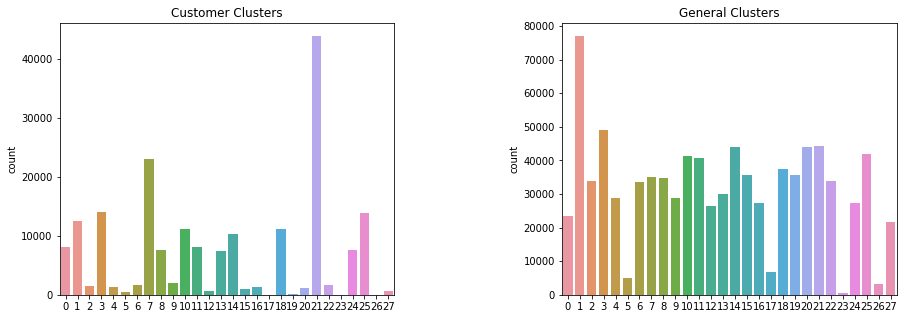

In [96]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
fig, axs = plt.subplots(nrows=1, ncols=2, figsize = (15,5))
fig.subplots_adjust(hspace = 1.0, wspace=.5)

sns.countplot(clients_preds, ax=axs[0])
axs[0].set_title('Customer Clusters')
sns.countplot(clusters_pred, ax=axs[1])
axs[1].set_title('General Clusters')


In [97]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
centroid_21 = scaler.inverse_transform(pca_2.inverse_transform(clusters.cluster_centers_[21]))
over_cluster = pd.Series(data = centroid_21, index = cols)

In [98]:
print(over_cluster)

ALTERSKATEGORIE_GROB        2.357727
ANREDE_KZ                   0.296398
FINANZ_MINIMALIST           3.761934
FINANZ_SPARER               3.176244
FINANZ_VORSORGER            3.588977
FINANZ_ANLEGER              3.800931
FINANZ_UNAUFFAELLIGER       4.291516
FINANZ_HAUSBAUER            2.573134
GREEN_AVANTGARDE            0.493547
HEALTH_TYP                  1.853464
LP_LEBENSPHASE_FEIN        40.394791
LP_LEBENSPHASE_GROB        12.011816
RETOURTYP_BK_S              3.572812
SEMIO_SOZ                   2.813611
SEMIO_FAM                   5.733033
SEMIO_REL                   6.015811
SEMIO_MAT                   4.367863
SEMIO_VERT                  2.613221
SEMIO_LUST                  5.412148
SEMIO_ERL                   3.055446
SEMIO_KULT                  3.443338
SEMIO_RAT                   3.019804
SEMIO_KRIT                  5.827934
SEMIO_DOM                   5.152664
SEMIO_KAEM                  4.959594
SEMIO_PFLICHT               4.077832
SEMIO_TRADV                 2.482216
S

In [99]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
centroid_23 = scaler.inverse_transform(pca_2.inverse_transform(clusters.cluster_centers_[23]))
under_cluster = pd.Series(data = centroid_23, index = cols)

In [100]:
print(under_cluster)

ALTERSKATEGORIE_GROB        2.274763
ANREDE_KZ                   0.083293
FINANZ_MINIMALIST           3.286885
FINANZ_SPARER              -1.504336
FINANZ_VORSORGER            7.378709
FINANZ_ANLEGER             -0.513630
FINANZ_UNAUFFAELLIGER      -0.881740
FINANZ_HAUSBAUER            6.721347
GREEN_AVANTGARDE           -1.235451
HEALTH_TYP                  2.206700
LP_LEBENSPHASE_FEIN        79.615516
LP_LEBENSPHASE_GROB        28.066827
RETOURTYP_BK_S              4.350853
SEMIO_SOZ                   4.635077
SEMIO_FAM                   4.269878
SEMIO_REL                   4.327041
SEMIO_MAT                   2.005277
SEMIO_VERT                  5.601584
SEMIO_LUST                  0.980621
SEMIO_ERL                   2.637768
SEMIO_KULT                  4.510285
SEMIO_RAT                   2.815572
SEMIO_KRIT                  3.638397
SEMIO_DOM                   4.116300
SEMIO_KAEM                  3.853821
SEMIO_PFLICHT               4.164612
SEMIO_TRADV                 0.680826
S

### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

+ As we can see at the plots Customer Clusters and General Clusters above, the Customer Cluster plot points that we can use the cluster of number 21, because it shows cluster 21 is the larger proportion of customer data.
+ We also can see at the plots that clusters of numbers 17, 19, 23 and 26 are the lower proportion of clients data, indicating that they are unpopular with the company.


> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.